# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [3]:
try:
    df = pd.read_csv('/datasets/data.csv', sep = '\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
    
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


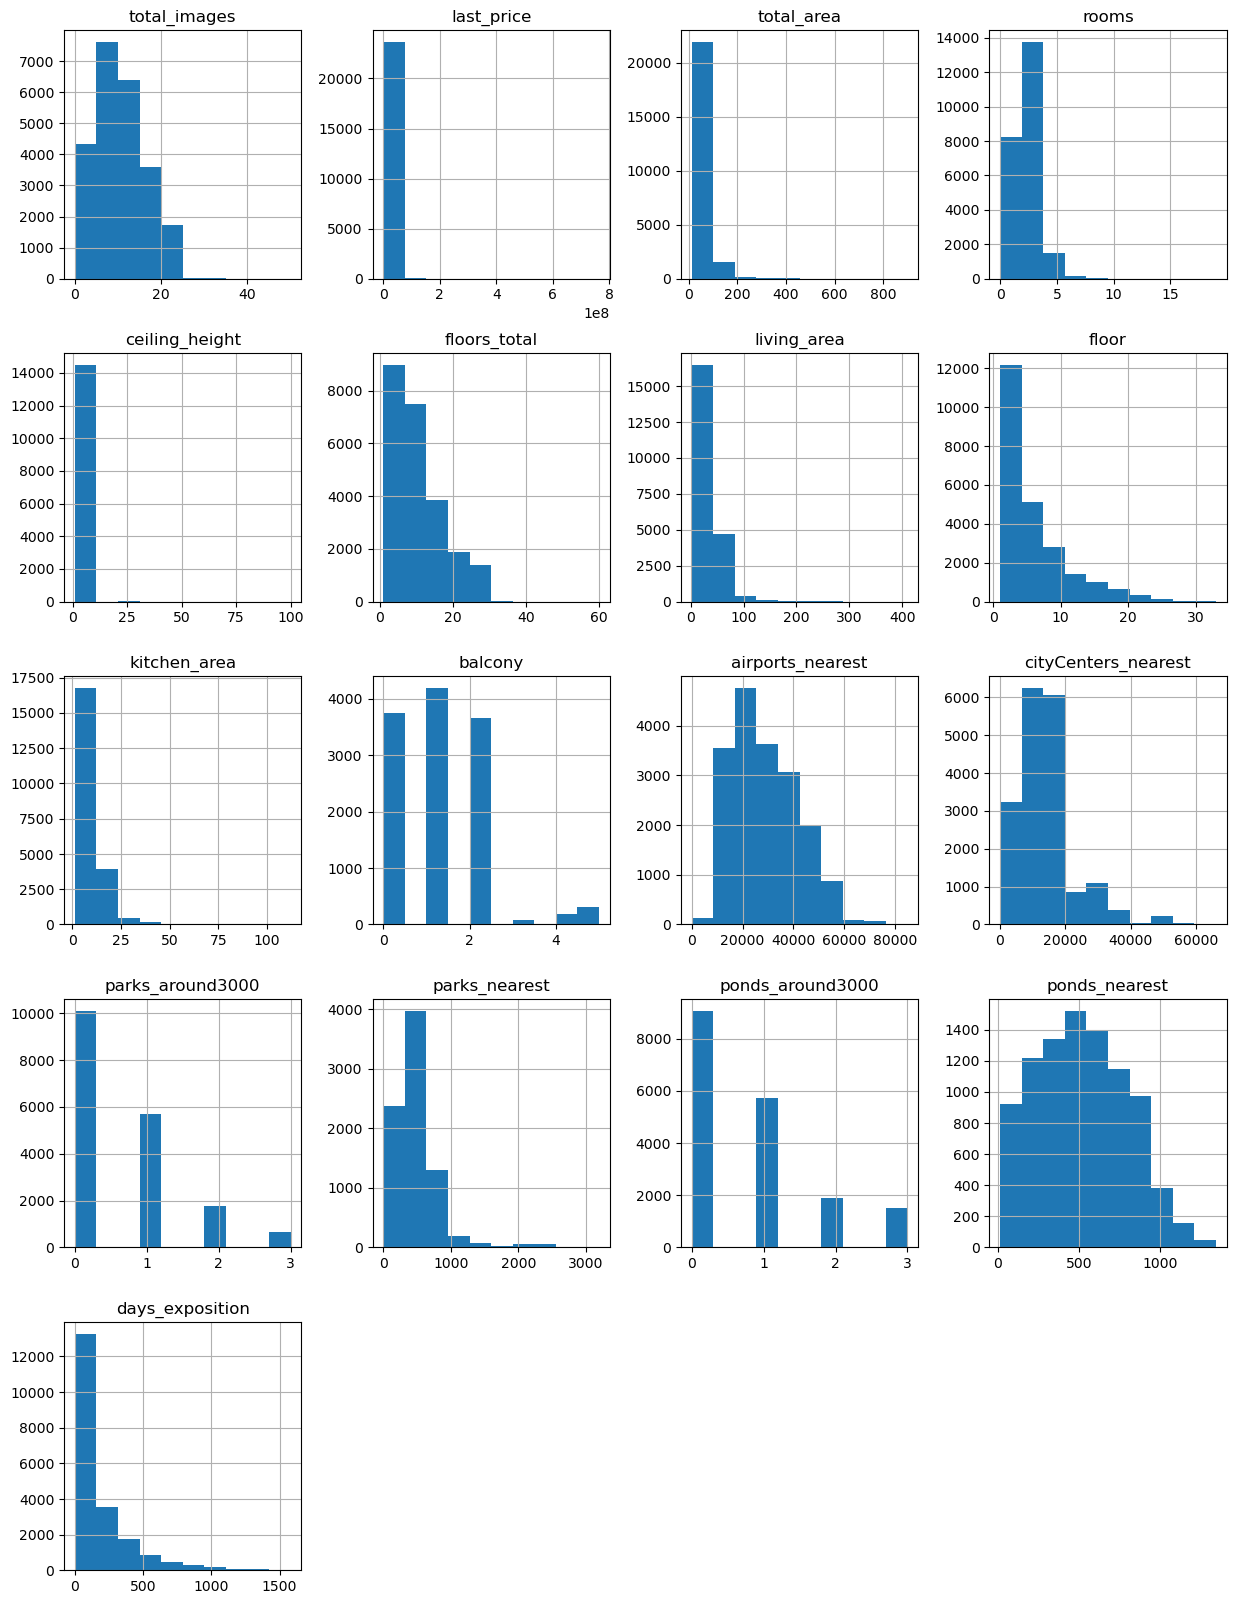

In [4]:
df.hist(figsize = (15,20))
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   


1. В гистограмме по `last_price` видно что есть сильно аномальные значения, и почти все значения сосредоточены до 100млн

2. В гистограмме по `total_area` также после 300 значений очень мало от всего количества

3. В гистограмме по `rooms` почти все данные сосредоточены до 8, остальных очень мало4

4. В гистограмме по `ceiling_height` видно много аномальных значений, возможно неправильный ввод

5. `is_apartment` не соответствует своему типу, скорее всего пропуски

6. `balcony`, `parks_around3000`, `ponds_around3000`, `airports_nearest`, `cityCenters_nearest` тип `float64`, должнен быть целочисленным, есть пропуски

7. В столбце `locality_name` скорее всего будут неявные дубликаты(человеческий фактор)

### Предобработка данных

In [6]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Первым делом проведем анализ населенных пунктов на наличия неявных совпадений и пропусков**

In [7]:
df['locality_name'].isna().sum()

49

**Мы не можем их как либо идентифицировать, а так же данных очень мало, поэтому можем их отбросить**

In [8]:
df = df.dropna(subset = ['locality_name'])

In [9]:
df['locality_name'] = df['locality_name'].str.lower().apply(lambda x : x.replace('ё','е'))

In [10]:
df['locality_name'].apply(lambda x : x.replace('ё','е')
                         .replace('поселок', '')
                         .replace('типа', '')
                         .replace('село', '')
                         .replace('деревня', '')
                         .replace('городского', '')
                         .replace('городской', '')
                         .replace('коттеджный', '')
                         .replace('садоводческое некоммерческое товарищество', '')
                         .replace('садовое товарищество', '')
                         .replace(' ', '')
                         ).unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красныйбор', 'гатчина', 'федоровское',
       'выборг', 'кронштадт', 'кировск', 'новоедевяткино', 'металлострой',
       'лебяжье', 'сиверский', 'молодцово', 'кузьмоловский', 'новаяропша',
       'павловск', 'пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'куттузи', 'аннино', 'ефимовский',
       'плодовое', 'заклинье', 'торковичи', 'первомайское', 'красное',
       'понтонный', 'сясьстрой', 'старая', 'лесколово', 'новыйсвет',
       'сланцы', 'путилово', 'ивангород', 'шлиссельбург', 'никольское',
       'зеленогорск', 'сосновыйбор', 'оржицы', 'кальтино', 'романовка',
       'бугры', 'рощино', 'кириши', 'луга', 'волосово', 'отрадное',
       'павлово', 'оредеж', 'копорье', 'молодежное', 'тихвин', 'победа',
       'нурма', 'синявино', 'тосно', 'стрельна', 'бокситогорск',
       'александ

In [11]:
df['locality_name'] = df['locality_name'].str.lower()
(df['locality_name'].apply(lambda x : x.replace('ё', 'е'))
 .unique())

array(['санкт-петербург', 'поселок шушары', 'городской поселок янино-1',
       'поселок парголово', 'поселок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина',
       'деревня федоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'поселок металлострой',
       'поселок городского типа лебяжье',
       'поселок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'поселок городского типа ефимовский', 'поселок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'поселок новый свет

In [12]:
df['locality_name'] = (df['locality_name'].replace('поселок мурино','мурино')
 .replace('деревня кудрово', 'кудрово')
 .replace('городской поселок федоровское',  'деревня федоровское')
 .replace('село никольское', 'никольское')
 .replace('городской поселок павлово','поселок городского типа павлово')
 .replace('село павлово', 'поселок городского типа павлово')
 .replace('городской поселок советский','поселок городского типа советский')
 .replace('городской поселок лесогорский', 'поселок городского типа лесогорский')
 .replace('городской поселок назия','поселок городского типа назия')
 .replace('поселок любань','любань')
 .replace('коттеджный поселок лесное', 'поселок лесное')
 .replace('городской поселок большая ижора','поселок городского типа большая ижора')
 .replace('поселок станции громово','поселок громово')
 .replace('садовое товарищество приладожский','поселок городского типа приладожский')
 .replace('поселок рябово','поселок городского типа рябово')
 .replace('садовое товарищество рахья','поселок городского типа рахья')
 .replace('поселок зимитицы','деревня зимитицы')
 .replace('городской поселок мга', 'поселок городского типа мга')
 .replace('поселок при железнодорожной станции вещево','поселок станции вещево'))

**Неявных дубликотов как и не было!**

**Проведем обработку столбца `ceiling_height`**

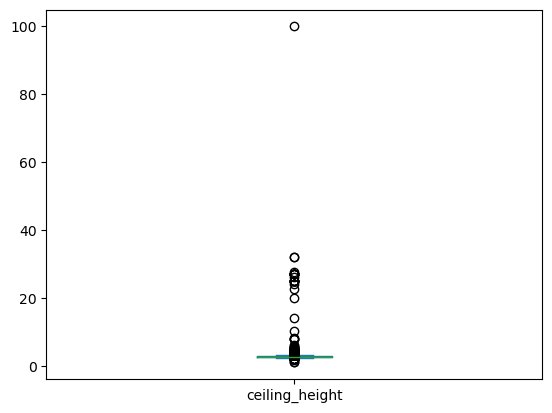

(0.0, 5.0)

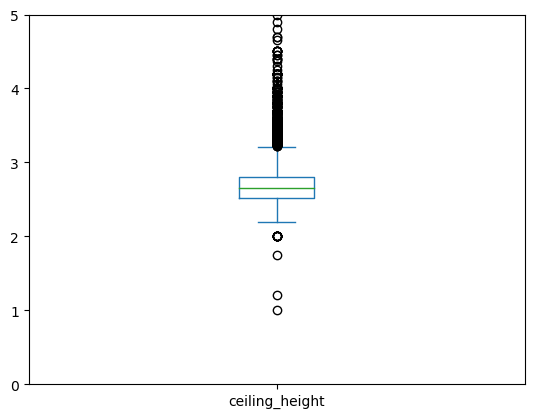

In [13]:
df['ceiling_height'].plot(kind = 'box')
plt.show()
df['ceiling_height'].plot(kind = 'box')
plt.ylim(0,5)

1. По графику видно присутствие выбросов, особенно с высотой потолка 100 метров, вряд ли это было ошибкой, если человек ошибся и хотел написать 10 метров, это все равно слишком много

2. Значения от 21 до 50 поделим на 10

3. Заполним пропуски медианным значением, чтобы выбросы не влияли, поставим граничное значение для нормальной высоты в 5м

In [14]:
df.loc[(df['ceiling_height'] >= 21) & (df['ceiling_height'] <= 50),'ceiling_height'] = (
df.loc[(df['ceiling_height'] >= 21) & (df['ceiling_height'] <= 50),'ceiling_height'] / 10)
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())


In [15]:
df.query('ceiling_height > 5').shape[0]

15

**Выбросим 15 значений, что меньше 1% всех данных, и не повлияет на полноту наших данных**

In [16]:
df = df.query('ceiling_height <= 5')

**Причиной пропусков может быть необязательность поля, и если человек не знает высоту потолка(что маловероятно, конечно) то он игнорировал это поле**


**Проведем обработку столбца `floors_total`**

In [17]:
df['floors_total'].describe()

count    23550.000000
mean        10.677028
std          6.595537
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot:>

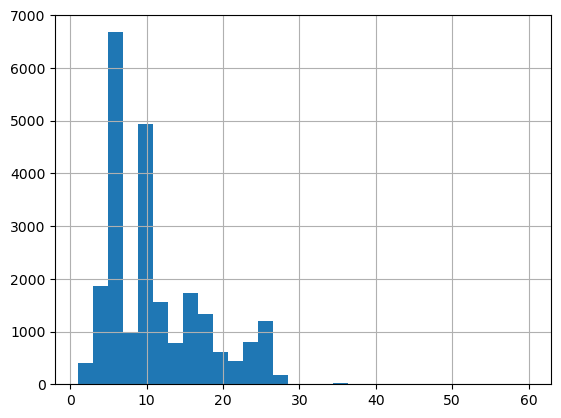

In [18]:
df['floors_total'].hist(bins = 30)

**Данные выглядят вполне логично, но присутствуют анормальные значения**

In [19]:
df.query('floors_total > 30')['floors_total'].describe()

count    32.000000
mean     36.375000
std       5.283877
min      33.000000
25%      35.000000
50%      35.000000
75%      35.000000
max      60.000000
Name: floors_total, dtype: float64

**Видно что среди домов выше 30 этажей 3 квантиль составляет 35, будем считать нормальными значениями высоту дома до 35 этажей**

In [20]:
df.query('floors_total > 35').shape[0]

6

**Всего 6 значений, можем их отбросить, они создают только лишний шум в данных, заменим пропущенные значения на медианные**

In [21]:
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median())
df = df.query('floors_total <= 35')

**По аналогии с высотой потолка, причиной может являться необязательность поля**

**Проведем обработку столбца `living_area`**

**Для этого сделаем группировку по городу и количеству комнат, и возьмем медианное значение, это позволит нам более точно описать пропущенные данные,
т.к есть прямая зависимость между количеством комнат и жилой площади, так и в городах медианная площадь может отличаться, особенно если дом находиться не в городе, а каком либо поселке/деревне и т.д**

In [22]:
df.corr().loc['living_area'].sort_values(ascending = False)

living_area            1.000000
total_area             0.939315
rooms                  0.846659
last_price             0.563791
kitchen_area           0.426918
ceiling_height         0.381827
parks_around3000       0.183091
ponds_around3000       0.150249
days_exposition        0.141720
total_images           0.104133
balcony                0.019725
open_plan             -0.033764
parks_nearest         -0.049660
studio                -0.057417
airports_nearest      -0.057617
ponds_nearest         -0.083211
floor                 -0.096941
floors_total          -0.168558
cityCenters_nearest   -0.230785
Name: living_area, dtype: float64

**На основе имеющихся данных мы видим огромную корреляцию между жилой площадью и общей площадью, что логично, поэтому сгрупируем по площади и возьмем медианное значение**

In [23]:
def fill_median_within_group(group):
    if np.isnan(group).sum() == group.size:
        median = np.nan
    else:
        median = group.median()
    return group.fillna(median)

In [24]:
df['living_area'] = (df.groupby(['total_area'])['living_area']
    .transform(lambda x: fill_median_within_group(x)))

In [25]:
df['living_area'].isna().sum()

142

**Еще 142 пропуска, так же есть кореляция с жилой площадью и количеством комнат, поэтому возьмем медианное по количеству комнат**

In [26]:
df['living_area'] = (df.groupby(['rooms'])['living_area']
    .transform(lambda x: fill_median_within_group(x)))

In [27]:
df['living_area'].isna().sum()

0

**После преобразований все пропущенные значения были заменены**

**Преобразуем столбец `is_apartment`**

In [28]:
df.groupby('is_apartment')['is_apartment'].count()

is_apartment
False    2709
True       49
Name: is_apartment, dtype: int64

**Большая часть значений пропущенных, а единица всего в 49 случаях, лучшим вариантом будет установка значения False, скорее всего поле не является обязательным, и продавец скорее всего принял решение его пропустить**

In [29]:
df['is_apartment'] = df['is_apartment'].fillna(False)

**Преобразуем столбец `kitchen_area` аналогично столбцу `living_area`**

In [30]:
df.corr().loc['kitchen_area'].sort_values(ascending = False)

kitchen_area           1.000000
total_area             0.607843
last_price             0.518646
living_area            0.427992
ceiling_height         0.335643
rooms                  0.269734
floors_total           0.165830
ponds_around3000       0.151217
floor                  0.136875
total_images           0.105080
days_exposition        0.101010
balcony                0.099536
parks_around3000       0.087614
is_apartment           0.049904
parks_nearest          0.029613
airports_nearest       0.007940
ponds_nearest         -0.105938
cityCenters_nearest   -0.191075
studio                      NaN
open_plan                   NaN
Name: kitchen_area, dtype: float64

In [31]:
df['kitchen_area'] = (df.groupby(['total_area'])['kitchen_area']
    .transform(lambda x: fill_median_within_group(x)))

In [32]:
df['kitchen_area'].isna().sum()

204

**Осталось еще 204 значений, это чуть меньше 1% всех данных, и их желательно сохранить, попробуем применим медианну по жилой площади для оставшихся**

In [33]:
df['kitchen_area'] = (df.groupby(['living_area'])['kitchen_area']
    .transform(lambda x: fill_median_within_group(x)))

In [34]:
df['kitchen_area'].isna().sum()

24

**Осталось всего 24 записи, и их можно выбросить**

In [35]:
df = df.dropna(subset = ['kitchen_area'])

<AxesSubplot:>

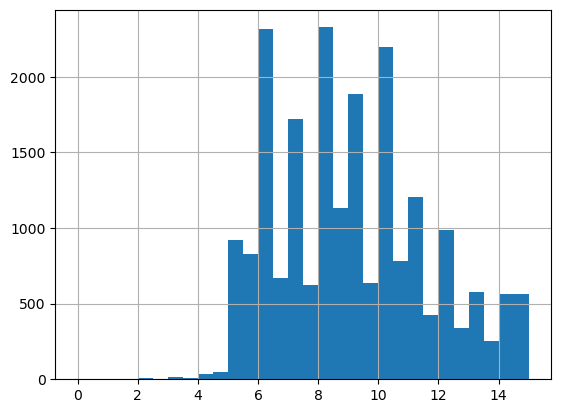

In [36]:
df['kitchen_area'].hist(bins = 30, range = (0, 15))

**Есть какие то аномально низкие значения, установим ограничения на 5м, записи лучше выбросить, т.к умножение на 10 может испортить наш анализ**

In [37]:
df = df.query('kitchen_area >= 5')

**Преобразуем столбец `balcony`**

**В этом случае лучшим вариантом будет 0, т.к скорее всего у продавца нет балкога и он пропустил это поле**

In [38]:
df['balcony'] = df['balcony'].fillna(0)

**В столцбах `parks_nearest` и `ponds_nearest` пропуски заменим нулями, скорее всего продавец их не указал, потому что их нет**

In [39]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)

**Столбцы `parks_nearest` и `ponds_nearest` никак не изменить, поэтому оставляем без изменений**

**Преобразуем типы данных**

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23483 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23483 non-null  int64  
 1   last_price            23483 non-null  float64
 2   total_area            23483 non-null  float64
 3   first_day_exposition  23483 non-null  object 
 4   rooms                 23483 non-null  int64  
 5   ceiling_height        23483 non-null  float64
 6   floors_total          23483 non-null  float64
 7   living_area           23483 non-null  float64
 8   floor                 23483 non-null  int64  
 9   is_apartment          23483 non-null  bool   
 10  studio                23483 non-null  bool   
 11  open_plan             23483 non-null  bool   
 12  kitchen_area          23483 non-null  float64
 13  balcony               23483 non-null  float64
 14  locality_name         23483 non-null  object 
 15  airports_nearest   

In [41]:
retype = {
         'total_area' : int,
         'floors_total' : int,
         'living_area' : int,
         'kitchen_area' : int,
         'balcony' : int,
         'parks_around3000' : int,
         'ponds_around3000' : int,
         }
df = df.astype(retype)


`total_area` - более удобная группировка, влияние на данные небольшое

`floors_total` - обязательно целое

`living_area` - более удобная группировка, влияние на данные небольшое

`kitchen_area` - более удобная группировка, влияние на данные небольшое

`balcony` - обязательно целое

`parks_around3000` - обязательно целое

`ponds_around3000` - обязательно целое

`days_exposition` - обязательно целое


### Добавление новых столбцов

**Добавим цену одного квадратного метра**

In [42]:
df['price_one_meter'] = df['last_price'] / df['total_area']

**Создадим функцию определения типа этажа**

In [43]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

**Найдем день недели публикации, месяц, год**

In [44]:
df['dayofweek_publish'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S').dt.dayofweek
df['month_publish'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S').dt.month
df['year_publish'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S').dt.year

df['floor_type'] = df[['floor','floors_total']].apply(floor_type, axis = 1)

df['cityCenters_nearest_km'] = (df['cityCenters_nearest']//1000)

### Проведите исследовательский анализ данных

**Построим диаграмму рассеивания по столбцам `total_area`, `living_area`, `kitchen_area`, `last_price`, `rooms`, `ceiling_height`, `floor`, `floors_total`**

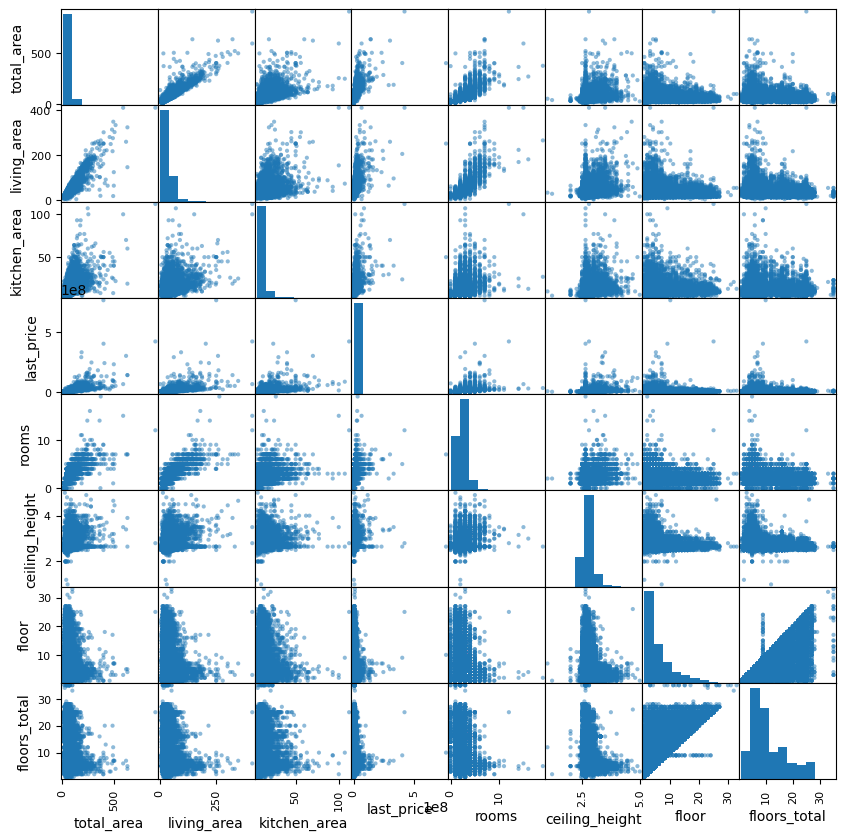

In [45]:
pd.plotting.scatter_matrix(df[['total_area', 'living_area', 'kitchen_area',
    'last_price', 'rooms', 'ceiling_height', 'floor', 'floors_total']], figsize = (10,10))
plt.show()

**Проанализируем столбец `total_area`**

Text(0, 0.5, 'Количество обьявлений')

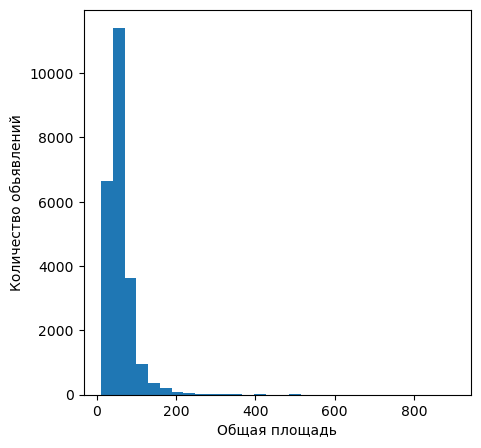

In [46]:
df['total_area'].plot(bins = 30, kind = 'hist', figsize = (5,5))
plt.xlabel('Общая площадь')
plt.ylabel('Количество обьявлений')

**Гистограмма показывает что данные имеют Пуассоновское распределние, нет каких то случайных пиков, и данные выглядят оптимально, данных по домам больше 300 кв. метров слишком мало, и уберем их из анализа**

**Посмотрим корреляцию**

In [47]:
df = df.query('total_area <= 300')

In [48]:
(df.corr()['total_area']
 [df.corr()['total_area'].apply(lambda x : abs(x) > 0.5)]).sort_values(ascending = False)

total_area      1.000000
living_area     0.932337
rooms           0.785221
last_price      0.676413
kitchen_area    0.596007
Name: total_area, dtype: float64

**Заметна прямая зависимость между площадью квартиры и жилой площадью, комнатами, ценой, что является реальным, так же, есть зависиомсть между площадью квартиры и площадью кухни и ценой , но корреляция не такая большая, скорее всего по причине что площадь кухни может зависить от местоположения обьекта, например, в городах площадь кухни скорее всего меньше чем в деревнях и поселках, точно так же и с ценой, одна и та же площадь стоит по разному в городе и за его пределами**

**Проанализируем столбец `living_area`**

Text(0, 0.5, 'Количество обьявлений')

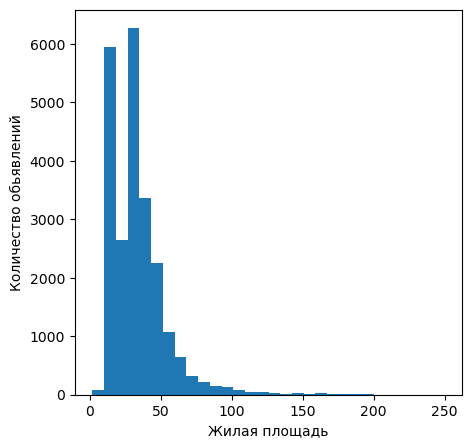

In [49]:
df['living_area'].plot(bins = 30, kind = 'hist', figsize = (5,5))
plt.xlabel('Жилая площадь')
plt.ylabel('Количество обьявлений')

**Гистограмма жилой площади очень схожа с общей плоащдью, ввиду их очень сильной корреляции, данные имеют Пуассоновское распределение, данных более 170 кв. метров очень мало, и по ним анализировать не получится, поэтому отбросим их**

**Посмотрим корреляцию**

In [50]:
df = df.query('living_area <= 150')

In [51]:
(df.corr()['living_area']
 [df.corr()['living_area'].apply(lambda x : abs(x) > 0.5)]).sort_values(ascending = False)

living_area    1.000000
total_area     0.924107
rooms          0.863148
last_price     0.563862
Name: living_area, dtype: float64

**Корреляцию между жилой площадью и общей площадью мы выявили еще на прошлом этапе, видна четкая корреляция между жилой площадью и количеством комнат, т.к жилой площадью являются именно комнаты, поэтому чем их больше тем выше жилая площадь, и наоборот. Так же есть средняя корреляция с ценой**

**Проанализируем столбец `kitchen_area`**

Text(0, 0.5, 'Количество обьявлений')

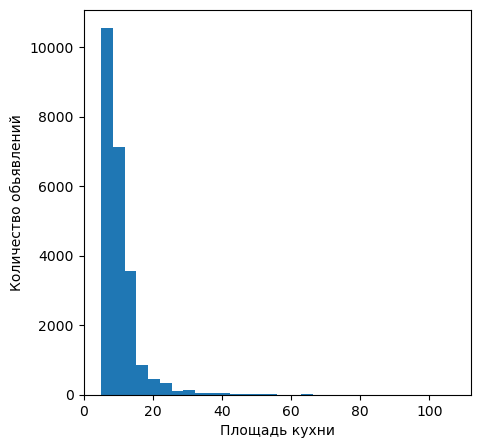

In [52]:
df['kitchen_area'].plot(bins = 30, kind = 'hist', figsize = (5,5))
plt.xlabel('Площадь кухни')
plt.ylabel('Количество обьявлений')

**Гистограмма схожа с гистограммами жилой площади и общей площадью, данных более 50 почти нет, и они могут испортить анализ, исключим их**

**Посмотрим корреляцию**

In [53]:
df = df.query('kitchen_area <= 50')

In [54]:
(df.corr()['kitchen_area']
 [df.corr()['kitchen_area'].apply(lambda x : abs(x) > 0.5)]).sort_values(ascending = False)

kitchen_area    1.000000
total_area      0.589359
Name: kitchen_area, dtype: float64

**Есть только небольшая корреляция с общей площадью, что является логичным заключением**

In [55]:
df['kitchen_area'].describe()

count    23314.000000
mean        10.047825
std          4.999565
min          5.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         50.000000
Name: kitchen_area, dtype: float64

**Проанализируем столбец `last_price`**

Text(0, 0.5, 'Количество обьявлений')

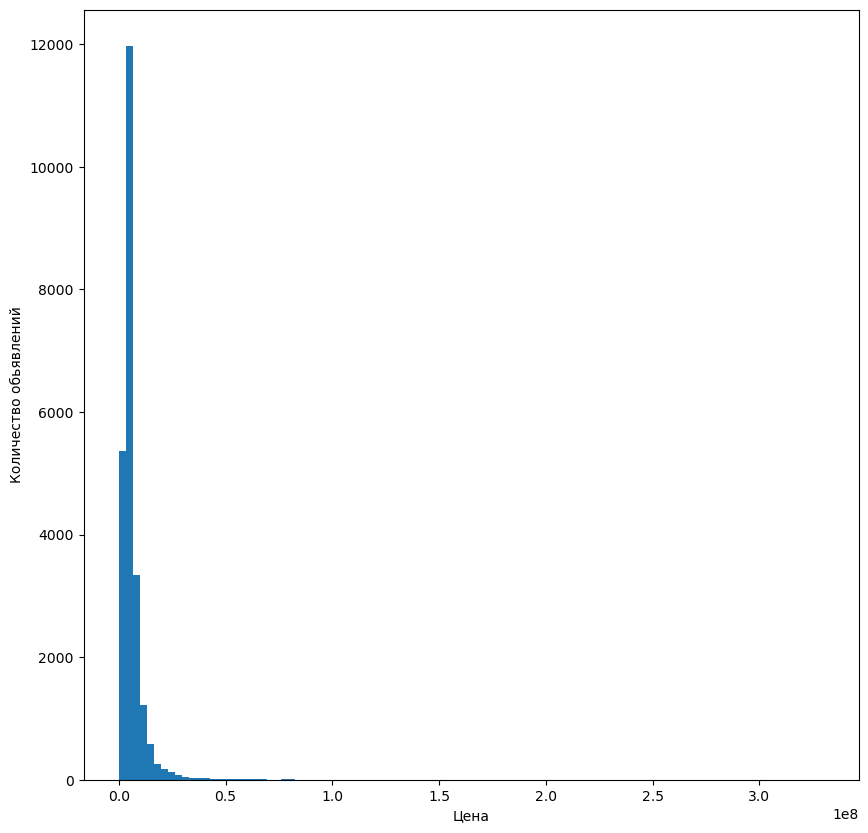

In [56]:
df['last_price'].plot(bins = 100, kind = 'hist', figsize = (10,10))
plt.xlabel('Цена')
plt.ylabel('Количество обьявлений')

Text(0, 0.5, 'Количество обьявлений')

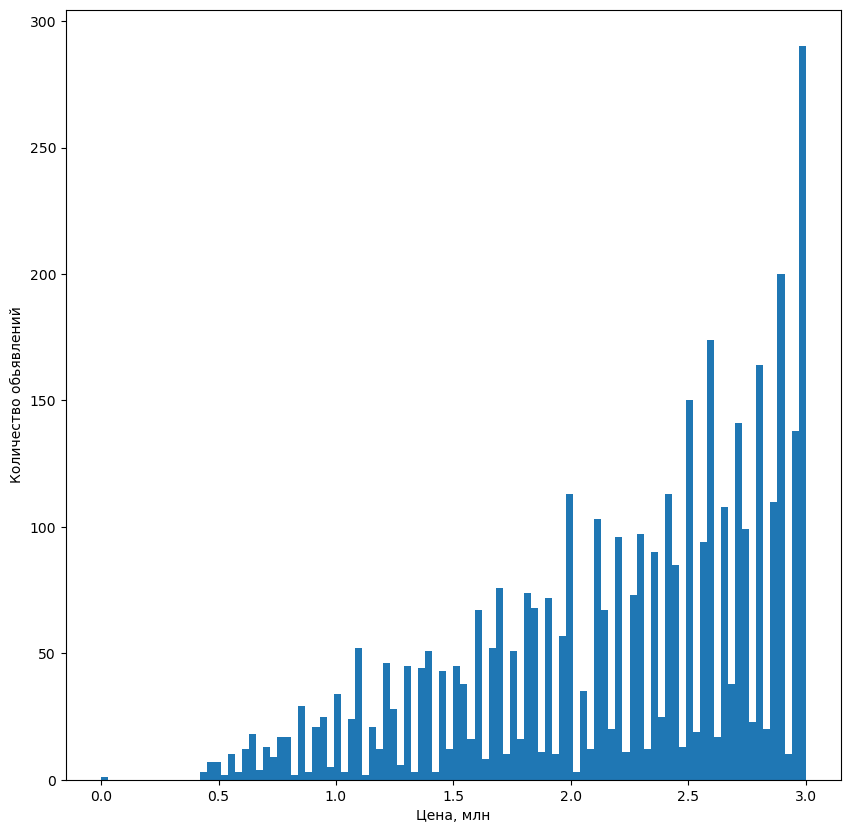

In [57]:
(df['last_price']/1e6).plot(bins = 100, kind = 'hist', figsize = (10,10), range = (0,3))
plt.xlabel('Цена, млн')
plt.ylabel('Количество обьявлений')

In [58]:
df['last_price'].describe()

count    2.331400e+04
mean     6.128513e+06
std      6.794951e+06
min      1.219000e+04
25%      3.426000e+06
50%      4.600000e+06
75%      6.700000e+06
max      3.300000e+08
Name: last_price, dtype: float64

**Минимальное значения 12000 тысяч, максимальное 330 милионоа, разброс огромный, 3 квантиль меньше 10 миллионов, отбросим значенения > 40 милионнов, для более правильной оценки, в качестве нижней нормы поставим 500 тысяч**

**Посмотрим корреляцию**

In [59]:
df = df.query('last_price <= 40000000 & last_price >= 500000')

In [60]:
(df.corr()['last_price']
 [df.corr()['last_price'].apply(lambda x : abs(x) > 0.5)]).sort_values(ascending = False)

last_price         1.000000
total_area         0.780834
price_one_meter    0.691221
living_area        0.678260
kitchen_area       0.597108
Name: last_price, dtype: float64

**Видна хорошая корреляция с общей площадью, что чаще всего определяют цену, так же есть внешний фактор, в виде населенного пункта**

**Проанализируем столбец `rooms`**

Text(0, 0.5, 'Количество обьявлений')

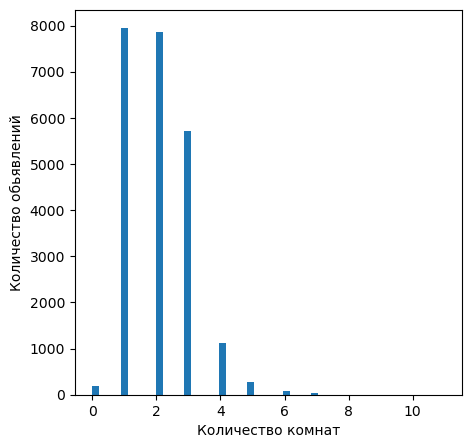

In [61]:
df['rooms'].plot(kind = 'hist', figsize = (5,5), bins = 50)
plt.xlabel('Количество комнат')
plt.ylabel('Количество обьявлений')

Text(0, 0.5, 'Количество обьявлений')

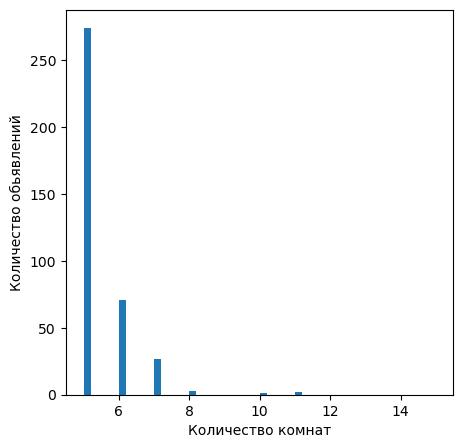

In [62]:
df['rooms'].plot(kind = 'hist', figsize = (5,5), bins = 50, range = (5,15))
plt.xlabel('Количество комнат')
plt.ylabel('Количество обьявлений')

**Есть записи где количество комнат 0, скорее всего это означает обьявления, где жилье не имеет прямого раздлеления на комнаты, записей где комнат > 7 очень мало, отбросим их для анализа**

**Посмотрим корреляцию**

In [63]:
df = df.query('rooms <=7 and rooms != 0')

In [64]:
(df.corr()['rooms']
 [df.corr()['rooms'].apply(lambda x : abs(x) > 0.3)]).sort_values(ascending = False)

rooms          1.000000
living_area    0.870122
total_area     0.786628
last_price     0.491253
Name: rooms, dtype: float64

**Есть явная зависимость между количеством комнат и жилой площадью, общей площадью, и небольшая корреляция с ценой**

**Проанализируем столбец `floor`**

Text(0, 0.5, 'Количество обьявлений')

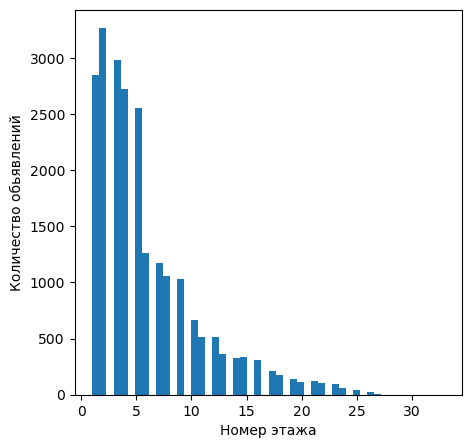

In [65]:
df['floor'].plot(kind = 'hist', figsize = (5,5), bins = 50)
plt.xlabel('Номер этажа')
plt.ylabel('Количество обьявлений')

Text(0, 0.5, 'Количество обьявлений')

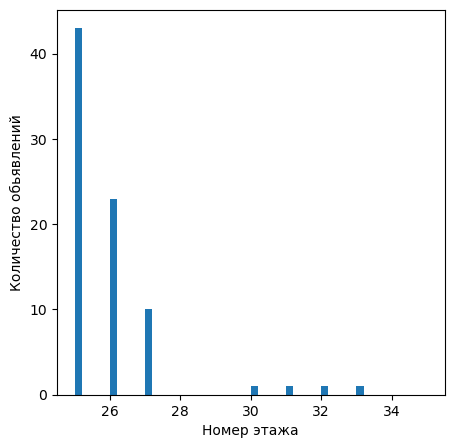

In [66]:
df['floor'].plot(kind = 'hist', figsize = (5,5), bins = 50, range = (25, 35))
plt.xlabel('Номер этажа')
plt.ylabel('Количество обьявлений')

**Данные имеют Пуассоновское распределение, после 27 этажа данных слишком мало, их отбросим**

**Посмотрим корреляции**

In [73]:
df = df[df['floor'] <= 27]

In [74]:
(df.corr()['floor']
 [df.corr()['floor'].apply(lambda x : abs(x) > 0.3)]).sort_values(ascending = False)

floor           1.000000
floors_total    0.674004
Name: floor, dtype: float64

**Нет каких либо зависимостей**

**Рассмотрим столбец `floor_type`**

Text(0, 0.5, 'Количество обьявлений')

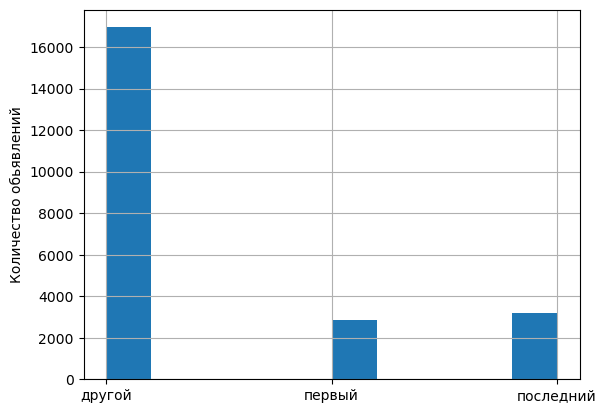

In [75]:
df['floor_type'].hist()
plt.ylabel('Количество обьявлений')

**Количество первых и последних этажей очень близко к друг другу, но вцелом составляют около 25% всех обьявлений** 

Text(0, 0.5, 'Количество обьявлений')

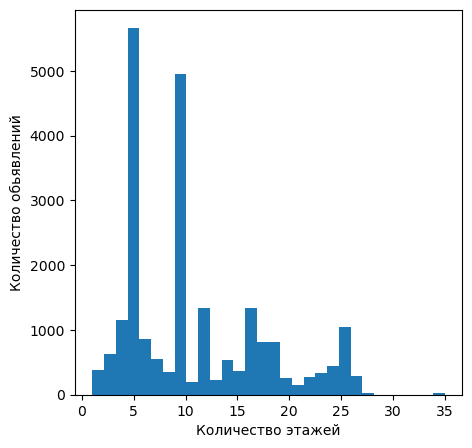

In [76]:
df['floors_total'].plot(kind = 'hist', figsize = (5,5), bins = 30)
plt.xlabel('Количество этажей')
plt.ylabel('Количество обьявлений')

**Видны два явных пика, при 5 этажах и 9 этажа, они отображают классическую городскую застройки 5 этажками и 9 этажками, малоэтажных домов очень мало**

**Проанализируем столбец `cityCenters_nearest`**

Text(0, 0.5, 'Количество обьявлений')

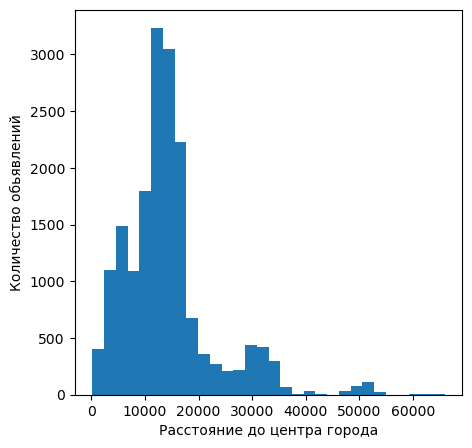

In [77]:
df['cityCenters_nearest'].plot(kind = 'hist', figsize = (5,5), bins = 30)
plt.xlabel('Расстояние до центра города')
plt.ylabel('Количество обьявлений')

**Данные распределены нормально, выделяющихся аномалий нет, большая часть обьявлений имеют расстояние от 0 до 35000м, данных с расстоянием больше 55000 м мало, но удалять мы их не можем, из-за большого количества пропусков**

**Посмотрим корреляцию**

In [78]:
(df.corr()['cityCenters_nearest']
 [df.corr()['cityCenters_nearest'].apply(lambda x : abs(x) > 0.3)]).sort_values(ascending = False)

cityCenters_nearest       1.000000
cityCenters_nearest_km    0.999425
last_price               -0.341486
price_one_meter          -0.373764
Name: cityCenters_nearest, dtype: float64

**Есть слабая корреляция с расстоянием до аэпорота и ценой за месяц, что может быть логично, т.к чем дальше от центра тем скорее всего ниже будет цена за схожие квартиры, так же есть слабая корреляция с ценой**

**Проведем анализ столбца `airports_nearest`**

Text(0, 0.5, 'Количество обьявлений')

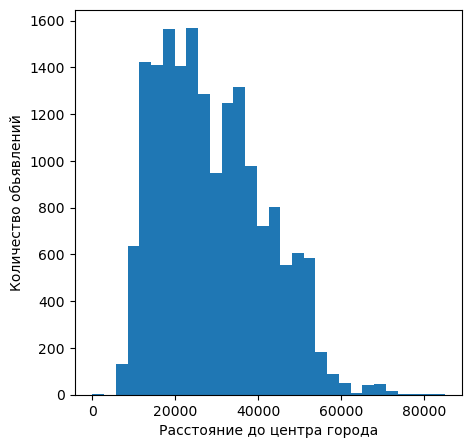

In [79]:
df['airports_nearest'].plot(kind = 'hist', figsize = (5,5), bins = 30)
plt.xlabel('Расстояние до центра города')
plt.ylabel('Количество обьявлений')

In [80]:
(df.corr()['airports_nearest']
 [df.corr()['airports_nearest'].apply(lambda x : abs(x) > 0.3)]).sort_values(ascending = False)

airports_nearest    1.0
Name: airports_nearest, dtype: float64

**Никакой связи**

**Проведем анализ столбца `parks_nearest`**

Text(0, 0.5, 'Количество обьявлений')

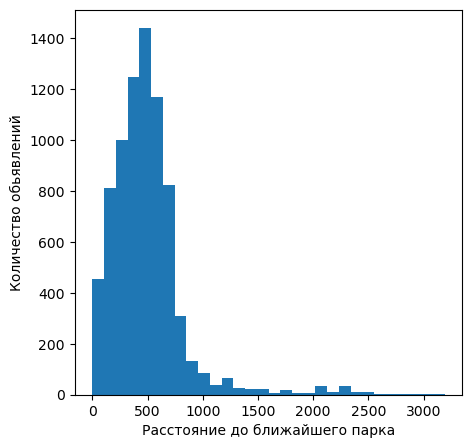

In [81]:
df['parks_nearest'].plot(kind = 'hist', figsize = (5,5), bins = 30)
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество обьявлений')

**На основе меньше чем половины данные по этому столбцу данные имеют Пуассоновское распределение**

**Посмотрим корреляцию**

In [82]:
(df.corr()['parks_nearest']
 [df.corr()['parks_nearest'].apply(lambda x : abs(x) > 0.3)]).sort_values(ascending = False)

parks_nearest    1.0
Name: parks_nearest, dtype: float64

**Никакой прямой корреляции нет**

**Проанализируем столбец `dayofweek_publish`**

Text(0, 0.5, 'Количество обьявлений')

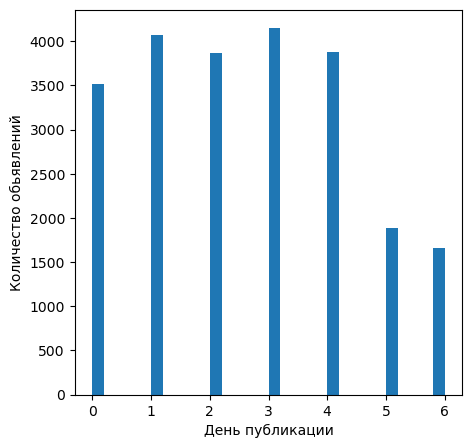

In [83]:
df['dayofweek_publish'].plot(kind = 'hist', figsize = (5,5), bins = 30)
plt.xlabel('День публикации')
plt.ylabel('Количество обьявлений')

**В будние дни количество обьявлений в 2 раза превышает количество в выходные в каждый день**

**Проанализируем столбец `month_publish`**

Text(0, 0.5, 'Количество обьявлений')

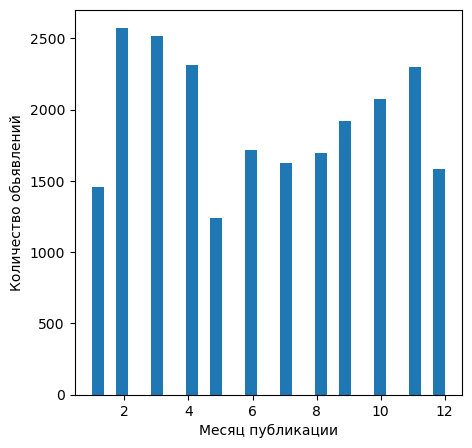

In [84]:
df['month_publish'].plot(kind = 'hist', figsize = (5,5), bins = 30)
plt.xlabel('Месяц публикации')
plt.ylabel('Количество обьявлений')

**В начале года и в конце когда, а так же летом видим что значения ниже чем остальные, так же наблюдается растущий тренд с мая по ноябрь**

**Посмотрим как быстро продавались дома**

Text(0, 0.5, 'Количество обьявлений')

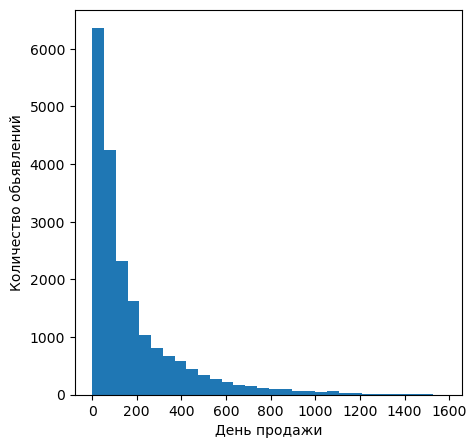

In [85]:
df['days_exposition'].plot(kind = 'hist', figsize = (5,5), bins = 30)
plt.xlabel('День продажи')
plt.ylabel('Количество обьявлений')

**Видная четкая закономерность, чем дольше продавался дом, тем меньше таких записей, попробуем установить быстрые продажи и медленные**

In [86]:
df['days_exposition'].describe()

count    19928.000000
mean       180.092232
std        218.801737
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [87]:
df['days_exposition'].median()

95.0

**Медианное значение 95 а среднее 180, отличие почти в два раза, поэтому в качестве быстрой продажи установим < Q1, долгой продажей использование третьего квантиля будет неоптимальным, т.к среднее значение слишком близко к третьему квантилю, поэтому попробую взять больший процентиль, возьмем 85 процентиль**

In [88]:
df['days_exposition'].quantile(0.85)

361.00000000000006

**Значит быстрыми продажами будет считать `days_exposition` < 45 дней, долгой `days_exposition` > 361 дней**

**Анализ цены**

**Посмотрим зависимость цены от общей площади**

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

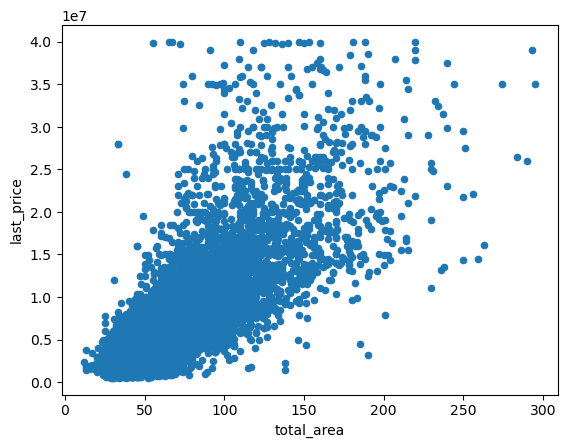

In [89]:
df[['last_price','total_area']].plot.scatter(x = 'total_area', y = 'last_price')

In [90]:
df[['last_price','total_area']].corr()

,last_price,total_area
last_price,1.00000,0.77967
total_area,0.77967,1.00000


**Вывод: Зависимость высокая**

**Посмотрим зависимость цены от общей площади**

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

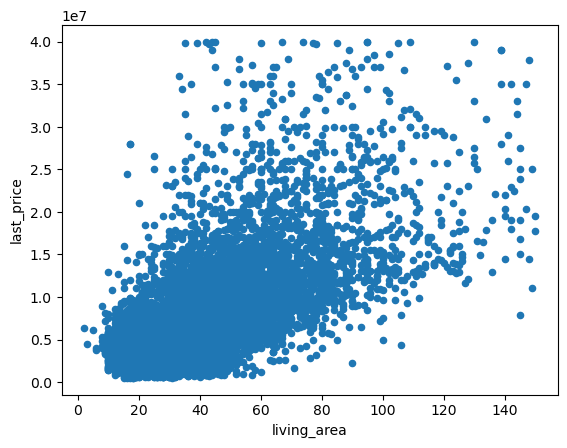

In [91]:
df[['last_price','living_area']].plot.scatter(x = 'living_area', y = 'last_price')

In [92]:
df[['last_price','living_area']].corr()

,last_price,living_area
last_price,1.000000,0.675701
living_area,0.675701,1.000000


**Вывод: Зависимость средне-высокая**

**Посмотрим зависимость цены от площади кухни**

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

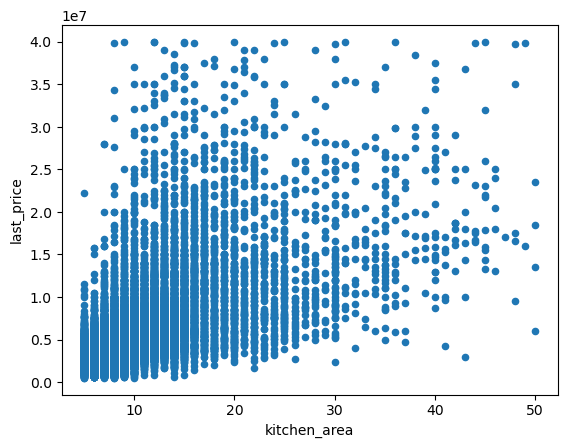

In [93]:
df[['last_price','kitchen_area']].plot.scatter(x = 'kitchen_area', y = 'last_price')

In [94]:
df[['last_price','kitchen_area']].corr()

,last_price,kitchen_area
last_price,1.000000,0.597232
kitchen_area,0.597232,1.000000


**Вывод: зависимость средняя**

**Посмотрим зависимость цены от количества комнат**

In [95]:
df.groupby('rooms')['last_price'].count()

rooms
1    7945
2    7853
3    5717
4    1118
5     274
6      71
7      27
Name: last_price, dtype: int64

**Данных по 5,6,7 комнатам мало, поэтому уберем их**

Text(0, 0.5, 'Медианная цена')

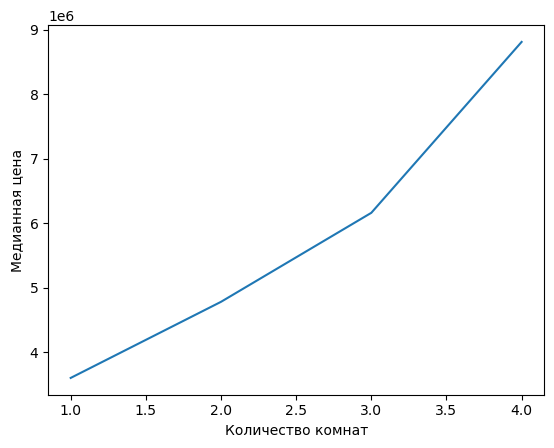

In [96]:
df.query('rooms not in [5,6,7]').groupby('rooms')['last_price'].median().plot()
plt.xlabel('Количество комнат')
plt.ylabel('Медианная цена')

**Количество комнат напрямую влияет на цену**

**Посмотрим зависимость цены от количества этажа**

<AxesSubplot:xlabel='floor_type'>

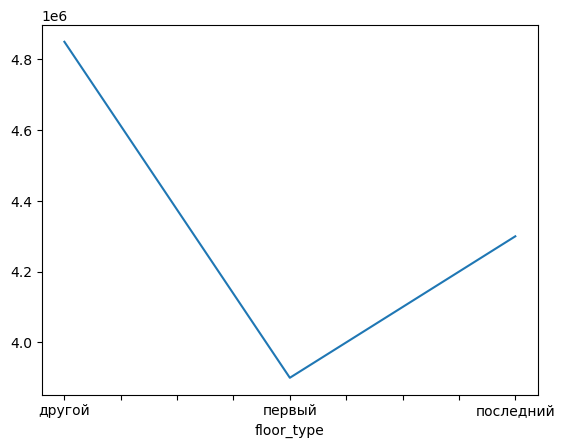

In [97]:
df.groupby('floor_type')['last_price'].median().plot()

**Вывод: квартиры на первом этаже продаются дешевле, потом последний этажа, и остальные этажи дороже всех, причиной этому, что на первом этаже люди не хотят жить, из-за плохого вида и других факторов, на последнем этаже причиной может быть проблемы с крышей и т.д.**

**Посмотрим зависимость цены от даты размещения**

In [98]:
df.groupby('dayofweek_publish')['last_price'].count()

dayofweek_publish
0    3513
1    4071
2    3864
3    4149
4    3873
5    1881
6    1654
Name: last_price, dtype: int64

**По всем дням данных достаточно**

In [99]:
df.groupby('dayofweek_publish')['last_price'].median()

dayofweek_publish
0    4650000.0
1    4720000.0
2    4700000.0
3    4600000.0
4    4590000.0
5    4550000.0
6    4550000.0
Name: last_price, dtype: float64

**Вывод: нельзя сказать что день напрямую влияет на цену, но и обратное сказать тоже нельзя**

**Посмотрим зависимость цены от месяца размещения**

In [100]:
df.groupby('month_publish')['last_price'].count()

month_publish
1     1454
2     2572
3     2516
4     2314
5     1240
6     1719
7     1627
8     1692
9     1917
10    2077
11    2295
12    1582
Name: last_price, dtype: int64

**По каждому месяцу данных достаточно для дальнейшего анализа**

<AxesSubplot:xlabel='month_publish'>

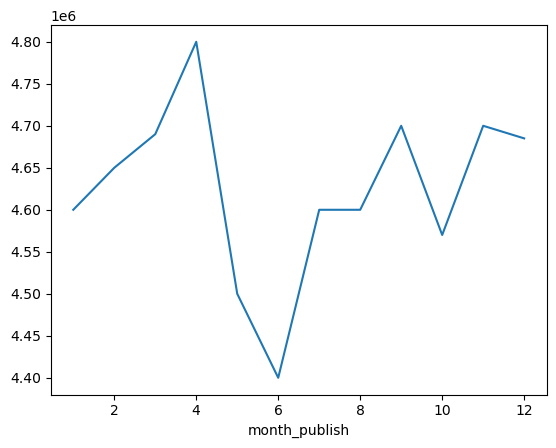

In [101]:
df.groupby('month_publish')['last_price'].median().plot()

**Есть зависимость, дома выставленные перед началом лета были проданы по самой низкой цене, возможной причиной может быть необходимость уезжать на отдых**

**Посмотрим зависимость цены от года размещения**

In [102]:
df.groupby('year_publish')['last_price'].count()

year_publish
2014     128
2015    1126
2016    2695
2017    7936
2018    8310
2019    2810
Name: last_price, dtype: int64

**За 2014 данных мало, поэтому уберем их из анализа**

<AxesSubplot:xlabel='year_publish'>

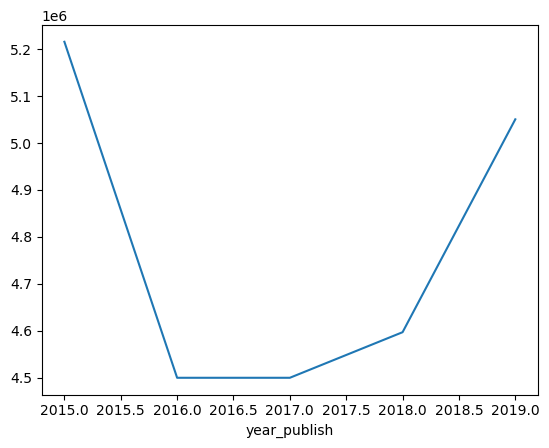

In [103]:
df.query('year_publish not in [2014]').groupby('year_publish')['last_price'].median().plot()

**Вцелом можно сказать что мы видим нарастающий тренд с 2017 года, после резкого упадка в 2016, возможно по внешним причиннам**

**Подсчитаем среднюю цену одного квадрата метра в 10 самых популярных городах**

In [104]:
most_popular = (df.groupby('locality_name')['locality_name']
                .count()
                .sort_values(ascending = False)[:10]
                .index
               )

In [105]:
(df.query('locality_name in @most_popular')
 .groupby('locality_name')['price_one_meter']
 .mean()
 .sort_values()[[0,-1]]
 )

locality_name
выборг              58343.735141
санкт-петербург    112026.606216
Name: price_one_meter, dtype: float64

**Дешевле всего в Выборге, дороже всего в Санкт-Петербурге**

<AxesSubplot:xlabel='cityCenters_nearest_km'>

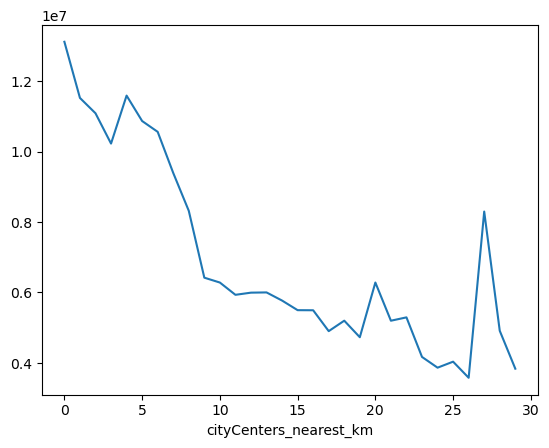

In [106]:
df.query('locality_name == "санкт-петербург"').groupby('cityCenters_nearest_km')['last_price'].mean().plot()

**Вцелом наблюдается уменьшение цены при увеличении расстояние от центра города, аномальным выбросом является 4, 20, 27 км от центра, причиной этому может быть местоположение богатого района, или расположенное важного культурного места**

### Общий вывод

1. Просмотр данных:

    1.1 Посмотрели первые значения в наших данных.
    
    1.2 Построили гистограммы всех столбцов, и посмотрели как выглядят наши данные.


2. Предобработка данных:

   2.1 Замена пропущенных значений:
    
   Столбцы `is_apartment`, `balcony`, `parks_around3000`, `ponds_around3000`, `parks_around3000`, `ponds_around3000` заменили на 0
        
   Столбцы `ceiling_height`, `floors_total`, `living_area`, `kitchen_area`, `days_exposition` заменили медианными значения, используя группировку по городу и/или общей площади, количеству комнат
      
   Столбец `locality_name` пришлось удалить все пропуски, т.к их нельзя идентифицировать, но они могут испортить анализ
      
   Столбцы `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest` оставили без изменения, т.к их невозможно идентифировать, но данных много  
      
   2.2 Устранение аномальных значений:
   
   Устранили в столбцах `ceiling_height`, `floors_total`, `kitchen_area`, `total_area`, `living_area`, `last_price`, `rooms`, `floor` аномальные значения, которые могли испортить результат анализа
   
   2.3 Устранение неявных дубликантов
   
   Столбец `locality_name` очищен от неявных дубликантов

3. Добавление новых столбцов:
   
   3.1 Столбец цены за 1 кв. метр 
   ```py
   df['price_one_meter'] = df['last_price'] / df['total_area']
   ```
   3.2 Столбец дня недели публикации
   ```py
   df['dayofweek_publish'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S').dt.dayofweek`
   ```
   3.3 Столбец месяца публикации
   ```py
   df['month_publish'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S').dt.month
   ```
   3.4 Столбец года публикации
   ```py
   df['year_publish'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S').dt.year
   ```
   3.5 Столбец типа этажа квартиры
   ```py
   df['floor_type'] = df[['floor','floors_total']].apply(floor_type, axis = 1)
   ```
   3.6 Столбец расстояние от центра города в километрах
   ```py
   df['cityCenters_nearest_km'] = (df['cityCenters_nearest']//1000)
   ```
4. Выводы анализа:

   4.1 Большое влияние на цену оказывает **общая площадь**, **жилая площадь**, **количество комнат**, **год публикации**  (растущий тренд), **месяц** (с мая по октябрь тренд растущий, но в мае самые низкие цены), **этаж** (первый самый дешевый, последний средний, остальные дороже всего)
   
   4.2 Быстрая продажа квартиры менее чем за 45 дней, долгая - более чем за 361 день
   
   4.3 Дешевле всех цена за 1 кв. метр в Выборге, дороже всего в Санкт-Петербурге
   
   4.4 Чем дальше от центра Санкт-Петербурга тем дешевле 1 кв. метр квартиры, исключение : 4,20,27 км от центра. Возможные причины : культурные места, богатые районы/пригороды
      